In [1]:
import os
from utils.configuration import *

In [2]:
experiment_name = "API_tramdagpaper_exp6_1_complexDGP_cs"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists/home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/configuration.json


In [4]:
# here you need to specify which varibles are in the graph and what type they are (continous or ordinal) for the model builder 
data_type= {'x1':'continous',
            'x2':'continous',
            'x3':'continous'} 

write_data_type_to_configuration(data_type, CONF_DICT_PATH)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | continous       | continuous [c]                 | continuous [c]                
---------------------------------------------------------------------------------------------------------
Configuration updated successfully.


/home/bule/TramDag/utils/configuration.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


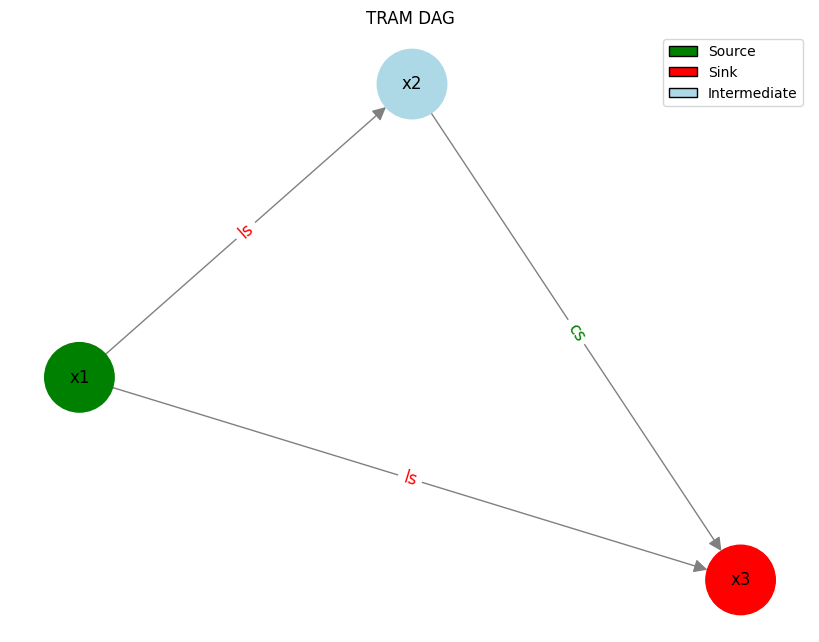

In [5]:
interactive_adj_matrix(CONF_DICT_PATH,seed=13)

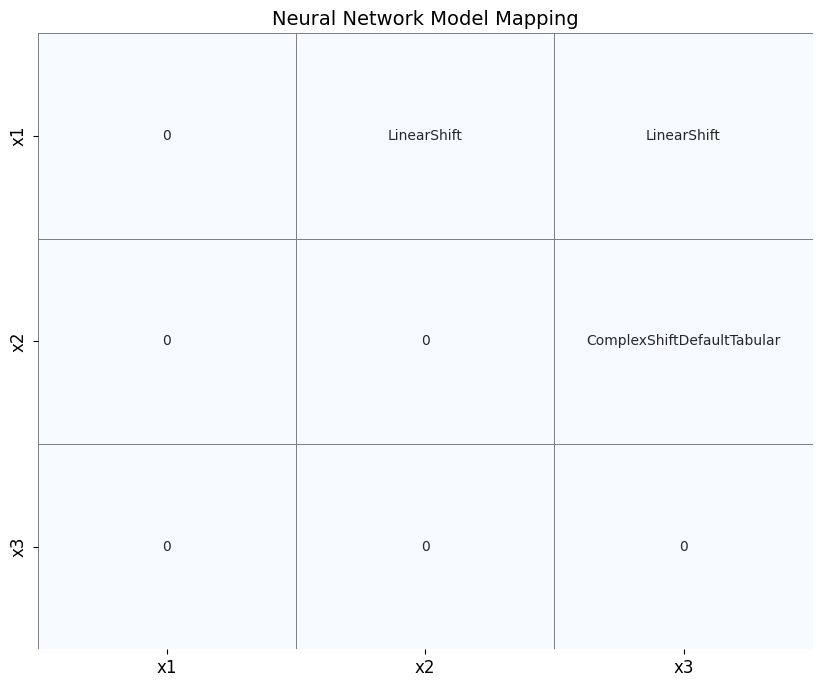

In [6]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import pandas as pd
from scipy.special import logit


# 1. Linear-shift DGP and linear-shift model 
def f(x):
    return 0.75*np.arctan(5*(x+0.12))  

def dgp(n_obs, doX=[None, None, None], seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")
    
    # Generate x1 from a 2-component GMM
    
    # h(x1)= SI 
    
    
    if doX[0] is None:
        x1_A = np.random.normal(0.25, 0.1, n_obs)
        x1_B = np.random.normal(0.73, 0.05, n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, x1_A, x1_B)
    else:
        x1 = np.full(n_obs, doX[0])



    # Fz(z)=Fy(y)
    # Fz(h(y|x))=Fy(y)    | z= h(y|x)

    # Generate x2
    
    # h(x2|x1)= Bernsteinpol(x2) + beta2 * x1        | bernsteinpol is just linearized assumed with a constant factor say 0.42
    # h(x2|x1)= 0.42*x2 + beta2 * x1                 | replace h(x2|x1) with z
    # z       = 0.42*x2 + beta2 * x1                 | reformulate to x2
    # x2      = (z-beta2 * x1 )/0.42                 | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x2      = (z-beta2 * x1 )/0.42                 | set beta = 2 (on the edge of the graph)
    # x2      = (z-2 * x1 )/0.42                     |
    
    if doX[1] is None:
        u2 = np.random.uniform(size=n_obs)
        z2 = logit(u2)
        x2 = (z2 - 2 * x1) / 5#5#   0.42  in the trainagle strucutred cont last line is 5 for SI
    else:
        x2 = np.full(n_obs, doX[1])

    # Generate x3
    
    # h(x3|x2,x1)= Bernsteinpol(x3) + beta3 * x1 -f(X2)        | bernsteinpol is just linearized assumed with a constant factor say 0.63
    # h(x3|x2,x1)= 0.63*x3 + beta3 * x1          - f(X2)        | replace h(x2|x1) with z
    # z3          = 0.63*x3 + beta3 * x1          - f(X2)        | reformulate to x2
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | set beta = -0.2 (on the edge of the graph)
    # x3         = (z3+0.2 * x1   +f(X2))/0.63                   | 

    
    if doX[2] is None:
        u3 = np.random.uniform(size=n_obs)
        z3 = logit(u3)
        x3 = (z3 + 0.2 * x1 + f(x2)) / 0.63
    else:
        x3 = np.full(n_obs, doX[2])
        
    #df = pd.DataFrame({'x1': x1, 'x2': x2})#, 'x3': x3})
    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
    return df

n_obs=100_000

df = dgp(n_obs=n_obs, seed=42)

# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

Setting Seed: 42


In [9]:
from utils.tramdag import TramDagConfig , TramDagModel

cfg = TramDagConfig.load("/home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/configuration.json")
device='cpu'

In [10]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=True,device=device,initial_data = train_df) 
# 1m52s

[DEBUG] TramDagModel using device: cpu

[INFO] Building model for node 'x1' with settings: {'set_initial_weights': False, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':              x1        x2        x3
75220  0.729475 -0.573516 -5.786670
48955  0.212327 -0.198221  1.468589
44966  0.219109  0.129154  0.384046
13568  0.777640  0.816980  0.975582
92727  0.357308 -0.411472  0.063509
...         ...       ...       ...
6265   0.700518 -0.365170 -6.182642
54886  0.217960 -0.776592 -1.728733
76820  0.209427 -0.405457  2.565484
860    0.741015  0.424173 -0.742044
15795  0.722792 -0.405650  0.273494

[80000 rows x 3 columns]}
[DEBUG] get_fully_specified_tram_model(): device: cpu
[DEBUG] default_number_thetas for continuous outcomes: 20
[DEBUG] Saved initial model state for node 'x1' to /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x1/initial_model.pt (overwrite=True)

[INFO] Building model for node 'x2' with settings: {'set_initial_weights': F

In [12]:
td_model.fit(train_df, val_df,
             epochs=260,batch_size=1_000,learning_rate=1e-2,
             verbose=True,debug=False,
             device=device,
             save_linear_shifts=True,
             save_simple_intercepts=True,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/min_max_scaling.json
[INFO] Training 3 nodes (sequential) on cpu

[INFO] Training node 'x1' for 260 epochs on cpu (pid=1246351)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x2' for 260 epochs on cpu (pid=1246351)
[INFO] Existing model found. Loading weights and history from LAST model...

===== Epoch 175/260 =====


[INFO] Saved linear shift weights for epoch 175 -> /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x2/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 175 -> /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x2/simple_intercepts_all_epochs.json
[INFO] Epoch 175: Train NLL=0.3451 | Val NLL=0.3399 | Time=1.34s

===== Epoch 176/260 =====
[INFO] Saved linear shift weights for epoch 176 -> /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x2/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 176 -> /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x2/simple_intercepts_all_epochs.json
[INFO] Epoch 176: Train NLL=0.3451 | Val NLL=0.3400 | Time=0.87s

===== Epoch 177/260 =====
[INFO] Saved linear shift weights for epoch 177 -> /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x2/linear_shifts_all_epochs.

[INFO] Loaded training/validation histories for 3 nodes.


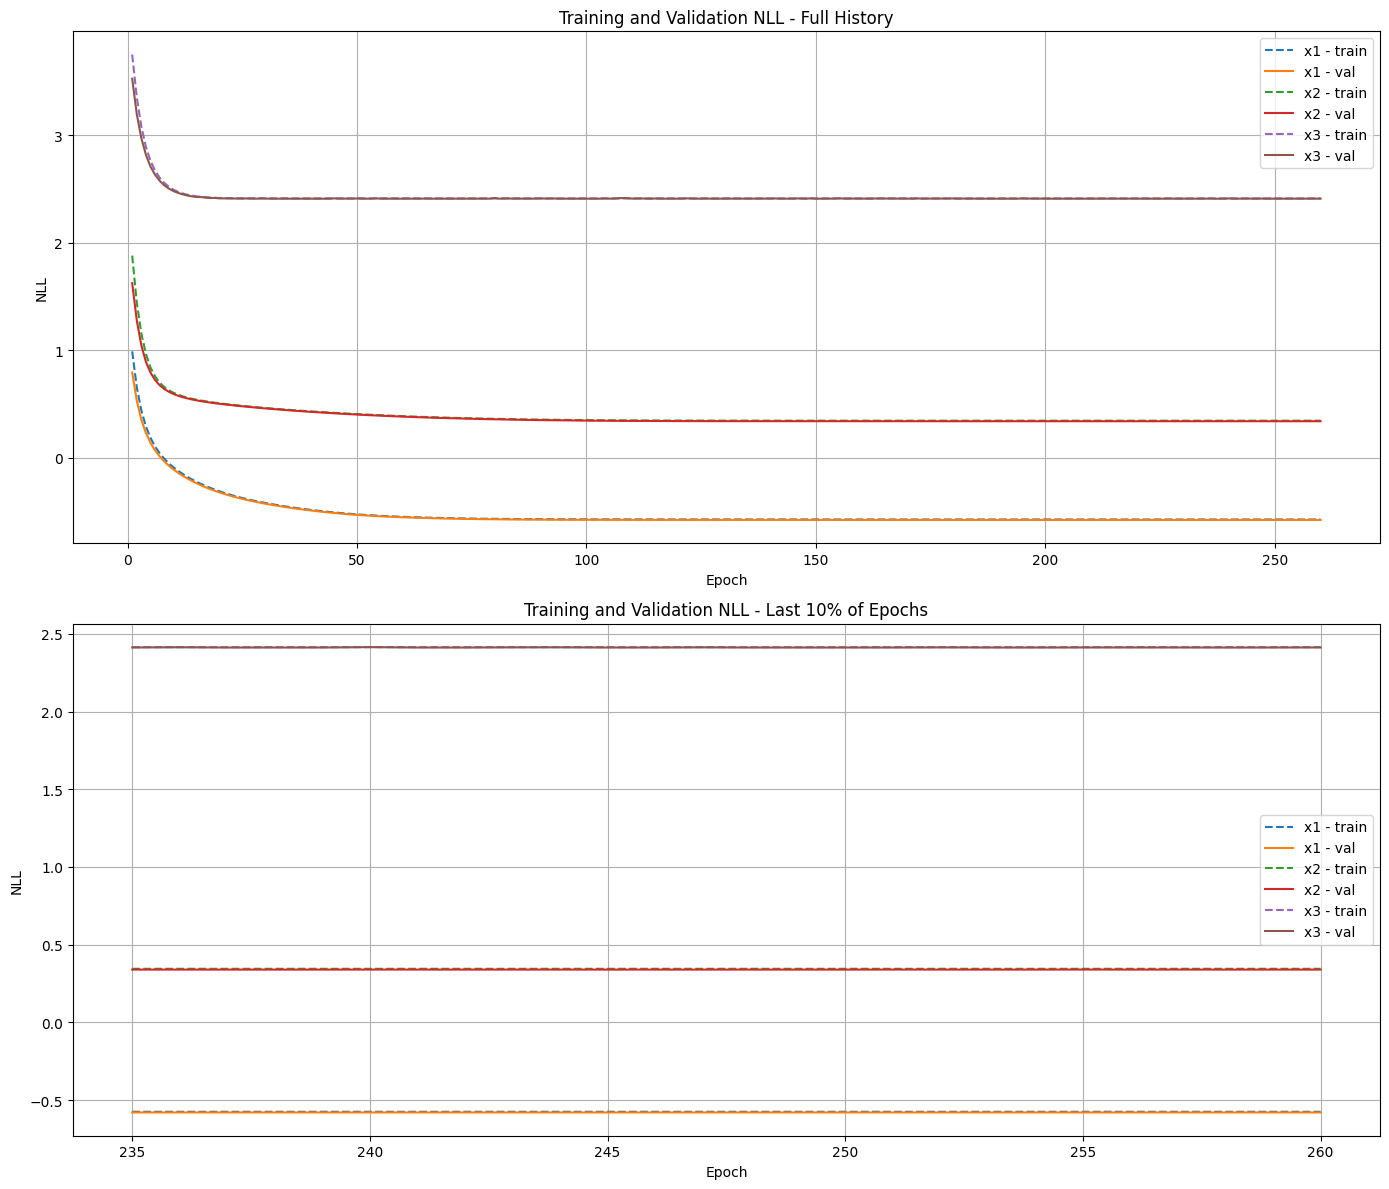

In [13]:
td_model.plot_loss_history()

[WARNING] No linear shift history found for node 'x1' at /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x1/linear_shifts_all_epochs.json


/home/bule/TramDag/utils/tramdag.py:1595: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


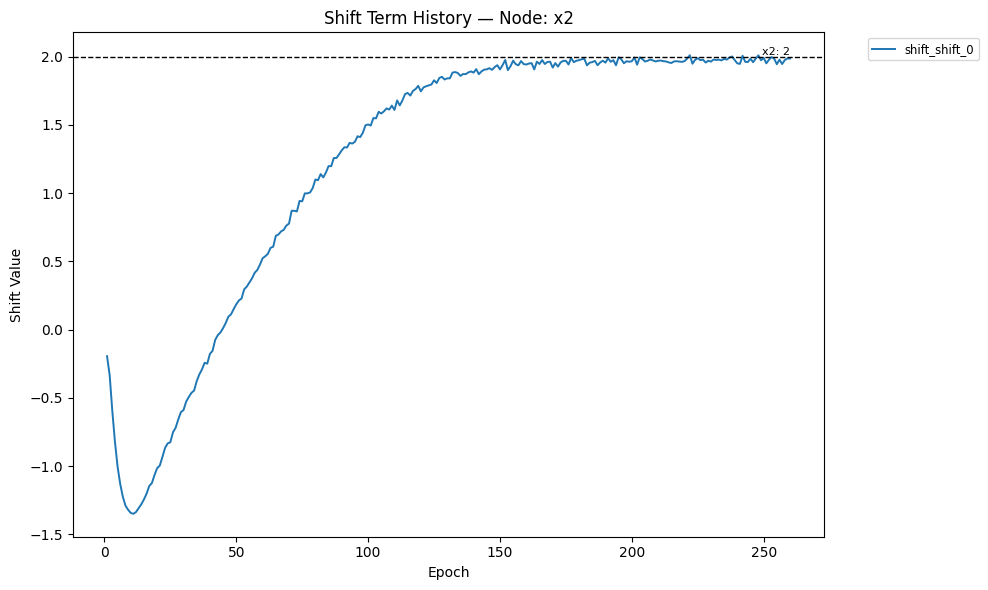

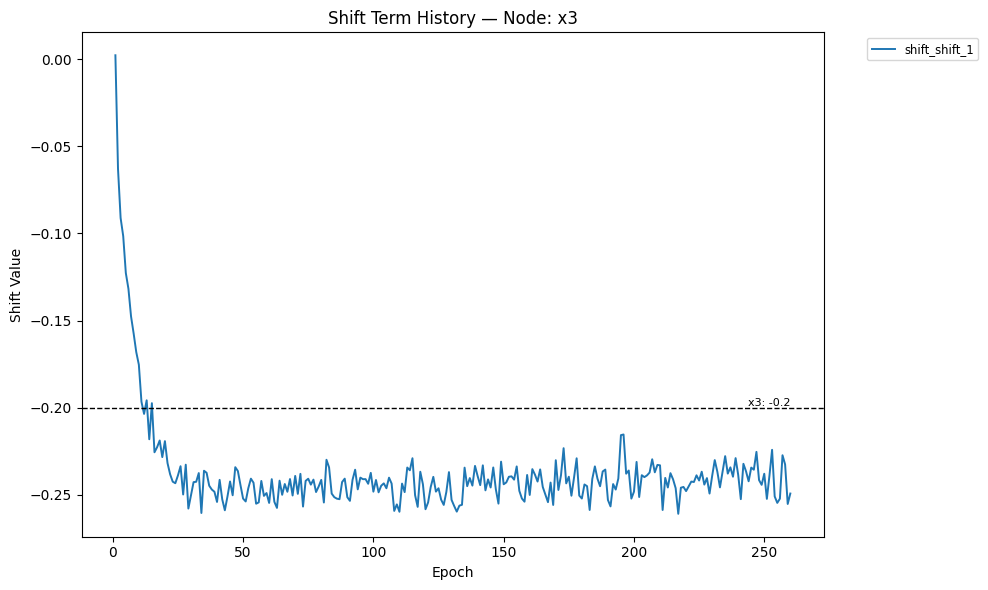

In [16]:
td_model.plot_shift_histories(ref_lines={'x2': [2],'x3': [-0.2]})


/home/bule/TramDag/utils/tramdag.py:1652: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


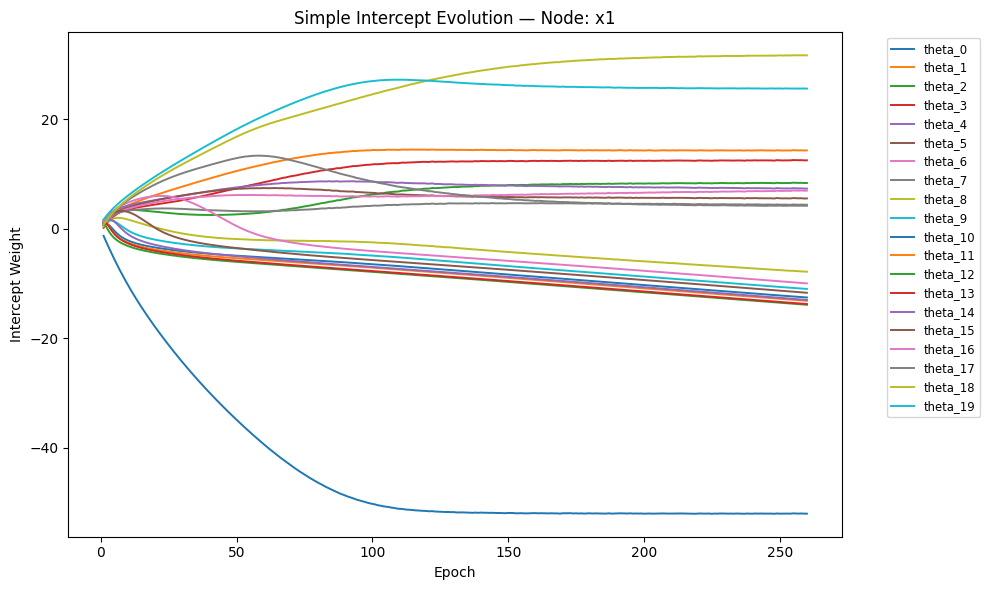

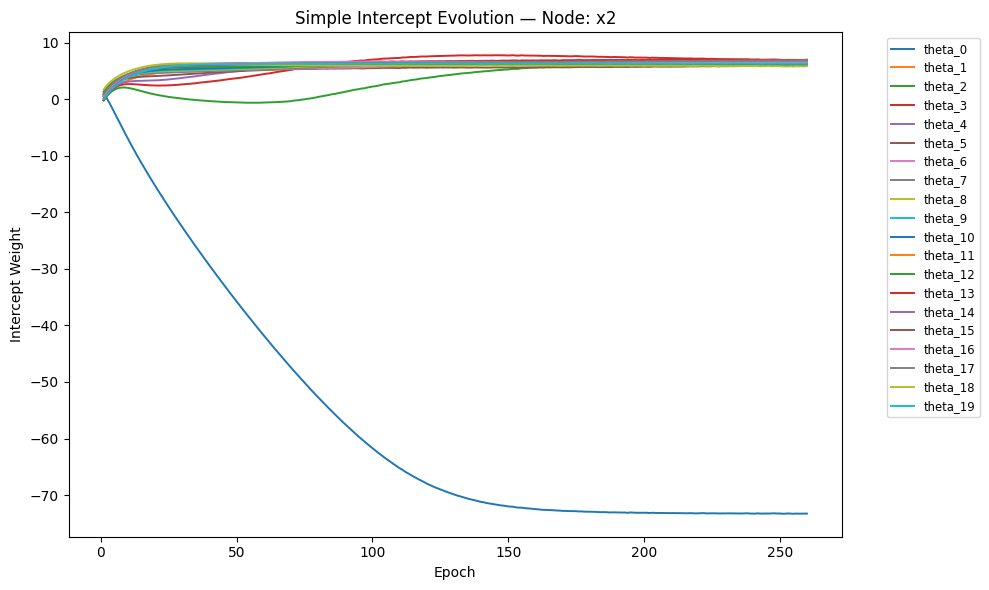

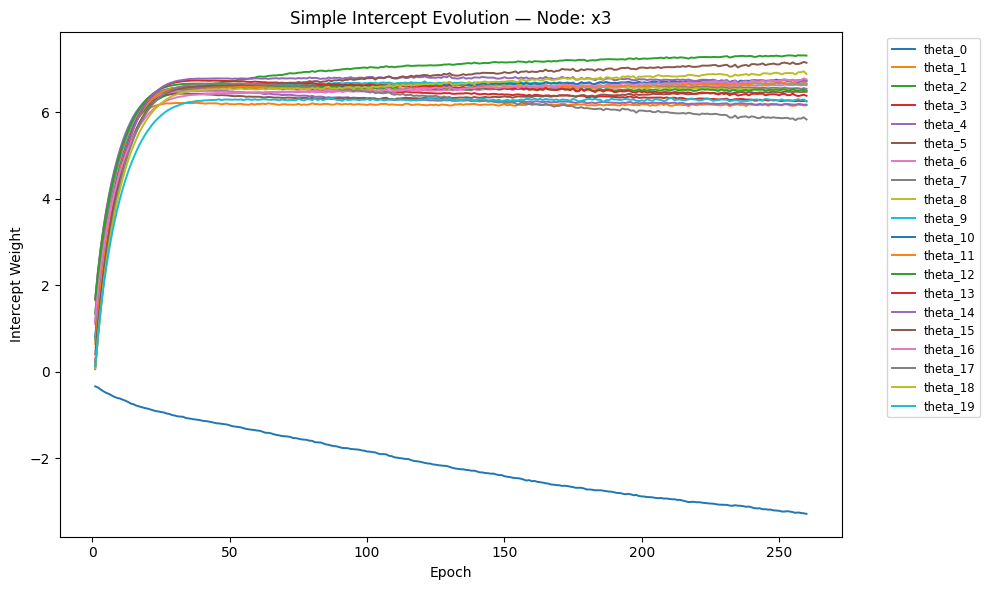

In [17]:
td_model.plot_simple_intercepts()

In [18]:
latents=td_model.get_latent( train_df)

[INFO] Final latent DataFrame shape: (80000, 6)


In [19]:
samples, latents = td_model.sample(device='cuda')

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Deleting all previously sampled data.
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x1/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x2/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x1 from standard logistic distribution
[INFO] Loaded best model weights for node 'x1' from /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x1/best_model.pt
[WARNING] target_col 'x1' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 282.48it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution
[INFO] Loaded best model weights for node 'x2' from /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x2/best_model.pt
[WARNING] target_col 'x2' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 320.09it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution
[INFO] Loaded best model weights for node 'x3' from /home/bule/TramDag/dev_experiment_logs/API_tramdagpaper_exp6_1_complexDGP_cs/x3/best_model.pt
[WARNING] target_col 'x3' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 317.72it/s]

[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


In [ ]:
samples, latents = td_model.sample(predefined_latent_samples_df=latents, device='cuda')

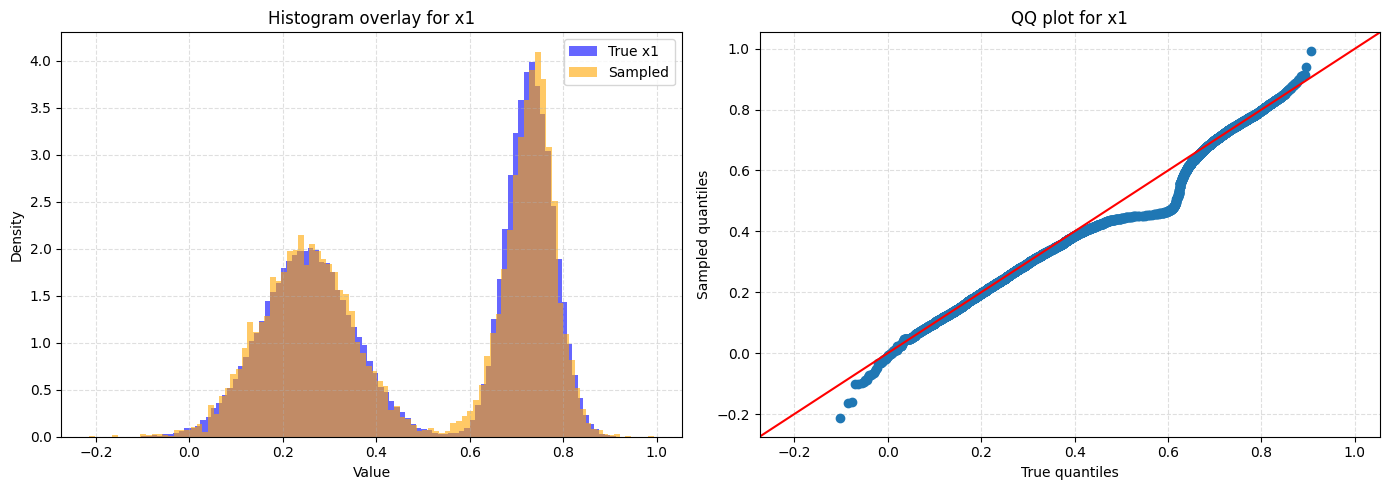

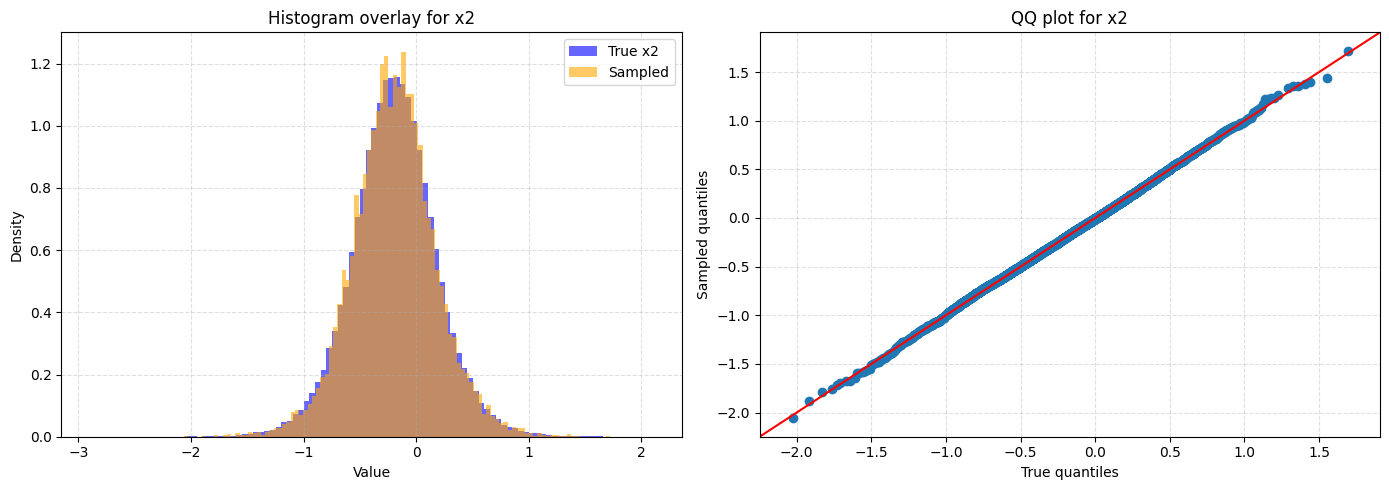

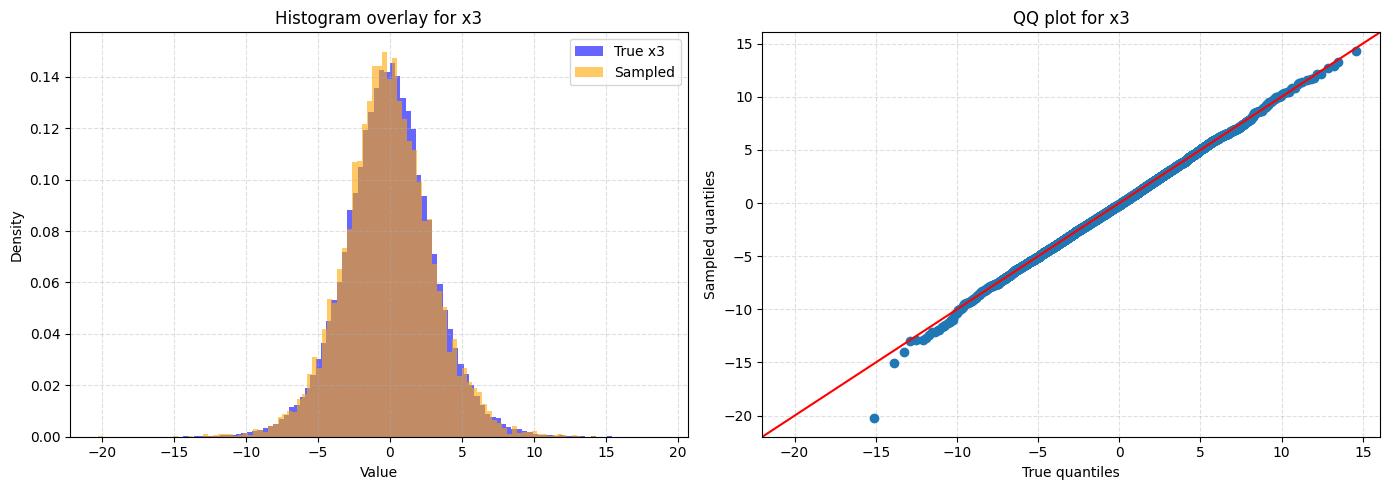

In [20]:
td_model.show_samples_vs_true(train_df)